In [1]:
import hashlib
import os
import os.path as op
import sys

import matplotlib.pyplot as plt
import numpy as np

factory_dir = r"C:/Users/Alan/Documents/hybridfactory/"
if not factory_dir in sys.path:
    sys.path.insert(0, factory_dir)
    
import factory.probes.eMouse as probe

In [2]:
%matplotlib notebook

We've run through our [eMouse demo notebook](https://gitlab.com/vidriotech/spiegel/hybridfactory/blob/master/notebooks/demos/make_eMouse-hybrid.ipynb) and want to see how well our scaling factor works.

In [3]:
eMouse_dir = r"C:/Users/Alan/Documents/hybridfactory/notebooks/demos/eMouse_demo/"

In [4]:
firings_true = np.load(op.join(eMouse_dir, "firings_true.npy")).astype(np.int64) # not big enough to need uint

`firings_true.npy` isn't standard yet, but is described like so:

- **First row** -- channels: The channel on which the event is centered.
- **Second row** -- times: The timestamps of the events in sample units.
- **Third row** -- labels: The integer labels for the unit identities.

Now we load up both `sim_binary.dat` and `sim_binary.GT.dat`, but before we do, let's ensure they're the right files.

In [5]:
def md5sum(filename):
    # hat tip to this guy: https://stackoverflow.com/questions/22058048/hashing-a-file-in-python#22058673
    chunk_size = 65536  # read in 64 KiB chunks

    result = hashlib.md5()

    with open(filename, "rb") as fh:
        while True:
            data = fh.read(chunk_size)
            if not data:
                break
            result.update(data)
            
    return result.hexdigest()

In [6]:
source_file = "sim_binary.dat"
target_file = "sim_binary.GT.dat"

assert md5sum(op.join(eMouse_dir, source_file)) == "3f810a1d4b9cb1a6c84d846e58b4fc6b"
assert md5sum(op.join(eMouse_dir, target_file)) == "ac48c8da96fb8235b4125e0cf6af31cb"

With that out of the way, let's do some before and after shots.

In [7]:
file_size_bytes = op.getsize(op.join(eMouse_dir, source_file))
byte_count = 2
nrows = probe.NCHANS
ncols = file_size_bytes // (nrows * byte_count)

source = np.memmap(op.join(eMouse_dir, source_file), dtype=np.int16, offset=0, mode="r",
                   shape=(nrows, ncols), order="F")
target = np.memmap(op.join(eMouse_dir, target_file), dtype=np.int16, offset=0, mode="r",
                   shape=(nrows, ncols), order="F")

<IPython.core.display.Javascript object>


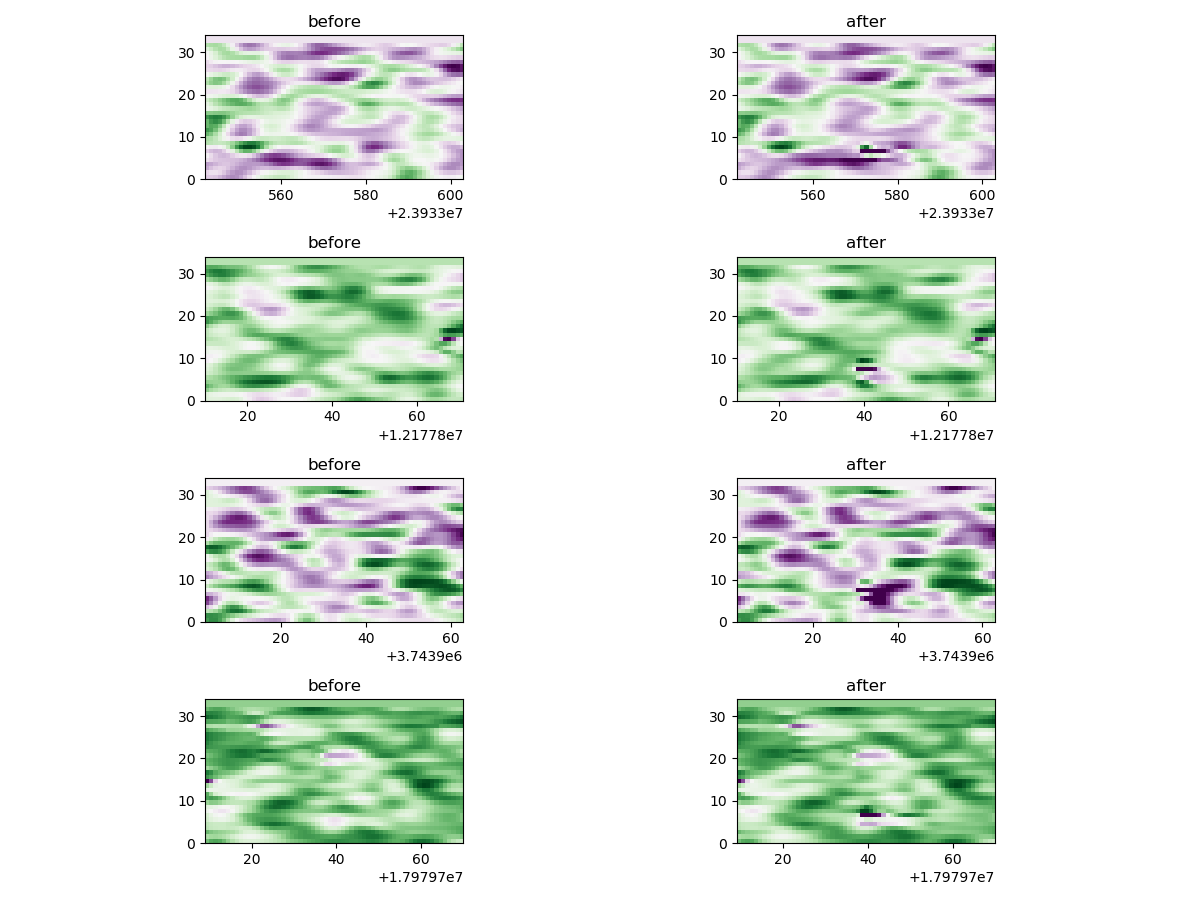

In [8]:
np.random.seed(1066)

fig, ax = plt.subplots(4, 2)

for i, k in enumerate(np.random.choice(firings_true.shape[1], size=4, replace=False)):
    t = firings_true[1, k]
    
    left = t - 30
    right = t + 31
    bottom = 0
    top = 34
    
    swin = np.array(source[:, left:right].copy())
    twin = np.array(target[:, left:right].copy())
    vmin = max(swin.min(), twin.min())
    vmax = min(swin.max(), twin.max())
    
    ax[i, 0].imshow(swin[probe.channel_map], "PRGn", extent=(left, right, bottom, top),
                    interpolation="nearest", vmin=vmin, vmax=vmax)
    ax[i, 0].set_title("before")
    #fig.colorbar(ax[i,0].images[0], ax=ax[i, 0])
    
    ax[i, 1].imshow(twin[probe.channel_map], "PRGn", extent=(left, right, bottom, top),
                    interpolation="nearest", vmin=vmin, vmax=vmax)
    ax[i, 1].set_title("after")
    
fig.set_size_inches([12, 9])
fig.tight_layout()

<IPython.core.display.Javascript object>


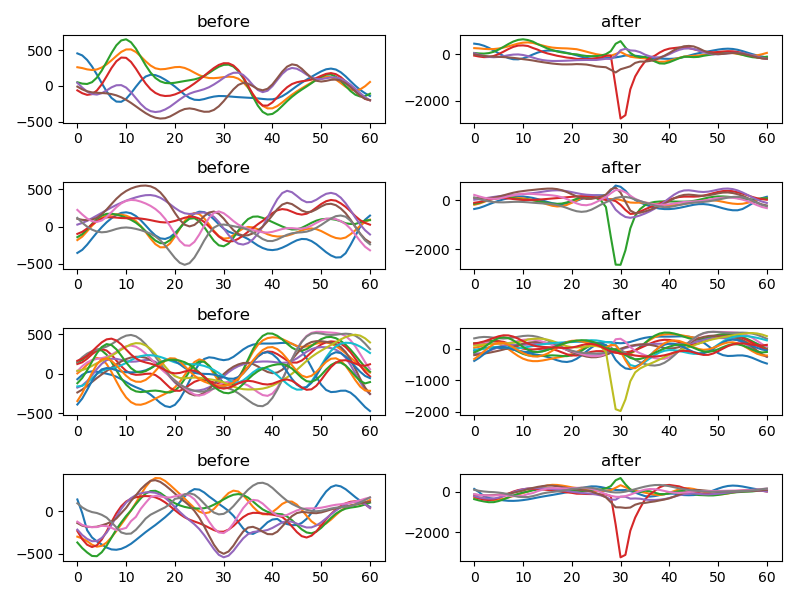

In [9]:
np.random.seed(1066)

fig, ax = plt.subplots(4, 2)

for i, k in enumerate(np.random.choice(firings_true.shape[1], size=4, replace=False)):
    chan, t = firings_true[:2, k]
    
    left = t - 30
    right = t + 31
    
    swin = np.array(source[:, left:right].copy())[probe.channel_map]
    twin = np.array(target[:, left:right].copy())[probe.channel_map]
    
    # find 
    rows = np.unique(np.nonzero(swin - twin)[0])
    
    ax[i, 0].plot(swin[rows, :].T)
    ax[i, 0].set_title("before")
    #fig.colorbar(ax[i,0].images[0], ax=ax[i, 0])
    
    ax[i, 1].plot(twin[rows, :].T)
    ax[i, 1].set_title("after")
    
fig.set_size_inches([8, 6])
fig.tight_layout()